In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Homework 8

**Instructions:** Complete the notebook below. Download the completed notebook in HTML format. Upload assignment using Canvas.

**Due:** Mar. 12 at **12:30pm.**

## Exercise: New-Keynesian Model Stochastic Simulation

### Equilibrium Conditions and Paramter Values

The most basic version of the New-Keynesian Model can be expressed as:

\begin{align}
y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
i_{t} & = \bar{r} + \pi^T + \phi_{\pi}\big(\pi_t - \pi^T\big) + \phi_{y}\big(y_t - \bar{y}\big)\\
\pi_t -\pi^T & = \beta \left( E_t\pi_{t+1} - \pi^T\right)  + \kappa (y_t -\bar{y})+ u_t,
\end{align}

where: $y_t$ is (log) output, $r_t$ is the real interest rate, $i_t$ is the nominal interest rate, $\pi_t$ is the rate of inflation between periods $t-1$ and $t$, $\bar{r}$ is the long-run average real interest rate or the *natural rate of interest*, $\beta$ is the household's subjective discount factor, and $\pi^T$ is the central bank's inflation target. The coeffieints $\phi_{\pi}$ and $\phi_{y}$ reflect the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output.

The variables $g_t$ and $u_t$ represent exogenous shocks to aggregate demand and inflation. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}
\end{align}

### Parameter Values:

You will use the following parameter values:

| $\bar{y}$ | $\beta$ | $\bar{r}$    | $\kappa$ | $\pi^T$ | $\phi_{\pi}$ | $\phi_y$ | $\rho_g$ | $\sigma_g^2$ | $\rho_u$ | $\sigma_u^2$ |
|-----------|---------|--------------|----------|---------|--------------|----------|----------|--------------|----------|--------------|
| 0         | 0.995   | $-\log\beta$ | 0.1      | 0.02/4  | 1.5          | 0.5/4    | 0.5      | 0.002<sup>2</sup>         | 0.5      | 0.001<sup>2</sup>        |


### Input Model and Solve

Refer to the Notebook for the week 9 discussion section for a complete example of how to input the model and solve. 

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series.
parameters = pd.Series()
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.1
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5
parameters['sigma_g_2'] = 0.002**2
parameters['sigma_u_2'] = 0.001**2

# Create variable called 'var_names' that stores the variable names in a list with state variables ordered first
var_names = ['g','u','y','pi','i','r']

# Create variable called 'shock_names' that stores an exogenous shock name for each state variable.
shock_names = ['e_g','e_u']

# Define a function that evaluates the equilibrium conditions of the model solved for zero.
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters
    p = parameters
    
    # Current variables
    cur = variables_current
    
    # Forward variables
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y - cur.i
    
    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)
    
    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g
    
    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equilibrium_equations,
                 n_states=2,
                 var_names=var_names,
                 shock_names=shock_names,
                 parameters = parameters)


# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [0,0,0,0.01,0.01,0.01]
nk_model.compute_ss(guess)

# Approximate and solve the model. Set log_linear argument to False since the model is already linear
nk_model.approximate_and_solve(log_linear=False)

### Stochastic Simulation

Construct a stochastic simulation of the New-Keynesian model with the follwoing properties:

1. 201 periods. 
2. Seed for random number generator: 126.

Note that the shock covariance matrix is:

\begin{align}
\text{Covariance matrix} & = \left[\begin{array}{cc}\sigma_g^2 & 0\\ 0 & \sigma_u^2\end{array}\right]
\end{align}

Use the following values for $\sigma_g^2$ and $\sigma_u^2$ in the simulation:

| $\sigma_g^2$      | $\sigma_u^2$      |
|-------------------|-------------------|
| 0.002<sup>2</sup> | 0.001<sup>2</sup> |

Refer to the Notebook for the week 7 discussion section for an example of how to use `linearsolve` to construct a stochastic simulation.

In [3]:
# Compute the simulation
nk_model.stoch_sim(T=201,seed=126,cov_mat=[[parameters['sigma_g_2'],0],[0,parameters['sigma_u_2']]])

### Analyze Simulation Results

Construct a plot with simulated output and inflation plotted together. Multiply simulated output by 100 and simulated inflation by 400 since, by convention, we always annualize inflation and interest rates.

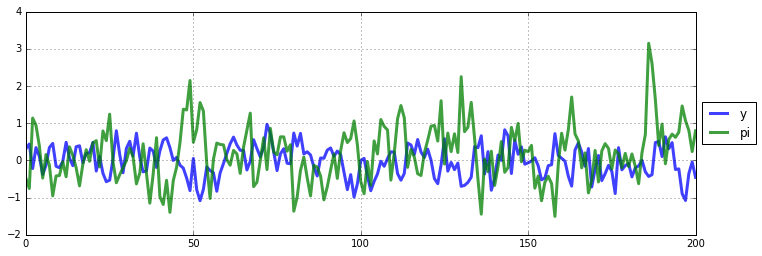

In [4]:
# Create a figure with dimensions 12x4. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create the left axis. PROVIDED
ax1 = fig.add_subplot(1,1,1)

# Plot the simulated series for output (times 100) and inflation (times 400)
(nk_model.simulated['y']*100).plot(ax=ax1,lw=3,alpha=0.75,grid=True)
(nk_model.simulated['pi']*400).plot(ax=ax1,lw=3,alpha=0.75,grid=True)

# Construct legend. PROVIDED
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Compute the standard deviations of inflation $\pi_t$ (times 400), output $y_t$ (times 100), and the nominal interest rate $i_t$ (times 400) for the simulated series.

In [5]:
print('pi:',round(nk_model.simulated[['pi']].std()[0]*400,5))
print('y: ',round(nk_model.simulated[['y']].std()[0]*100,5))
print('i: ',round(nk_model.simulated[['i']].std()[0]*400,5))

pi: 0.74496
y:  0.41778
i:  1.03754


Compute the coefficients of correlation of inflation $\pi_t$, output $y_t$, and the nominal interest rate $i_t$ for the simulated series.

In [6]:
nk_model.simulated[['pi','y','i']].corr()

,pi,y,i
pi,1.000000,-0.462278,0.983935
y,-0.462278,1.000000,-0.296543
i,0.983935,-0.296543,1.000000


**Questions**

1. In the smulation data, which variable fluctuates more, inflation (times 400) or output (times 100)?
2. Do the simulations suggest a positive or negative correlation between output and inflation?
3. Note that for the simulations, it was assumed that the variances on the inflation and demand shocks were about the same. Based on the answer to your previous question, which shocks appear to have a dominant effect on the dynamics of the model?

**Answers**

1. Inflation. <!-- answer -->
2. A negative correlation between output and inflation. <!-- answer -->
3. It appears that the inflation shocks dominate because the model implies that output and inflation are negatively correlated following inflation shocks but positively cerrelated following demand shocks. Since both shocks are occuring simultaneously, it's apparent that the inflation shocks dominate the demand shocks. <!-- answer -->